### Full name: Hanan ATMANI

#### Exercise1:

Let's GPU accelerate a "zero suppression" function. A common operation when working with waveforms is to force all sample values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

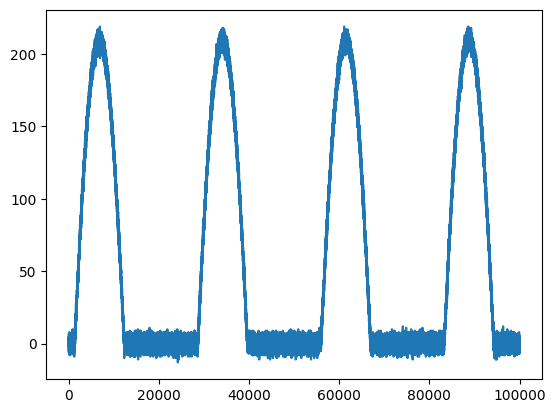

In [ ]:
# This allows us to plot right here in the notebook
%matplotlib inline
# Hacking up a noisy pulse train
from matplotlib import pyplot as plt
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


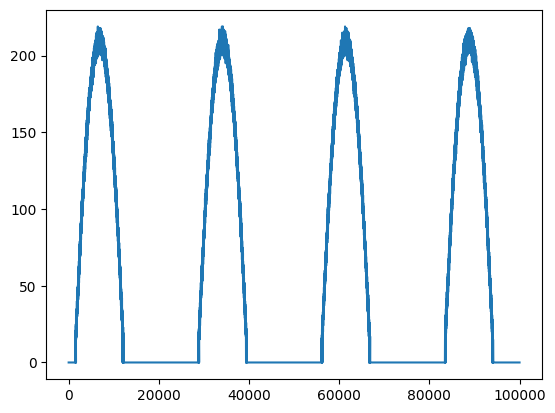

In [ ]:
from numba import vectorize, cuda
# Générer des données de forme d'onde
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)

# Décorer la fonction zero_suppress pour l'exécution sur le GPU
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result

# Appliquer la fonction zero_suppress aux données de la forme d'onde
waveform_Noise_supp = zero_suppress(waveform, 15)

# Tracer les données filtrées
plt.plot(waveform_Noise_supp)
plt.show()


#### Exercise 2: Optimize Memory Movement

In [ ]:
import math
@vectorize(['float32(float32, float32, float32)'], target = 'cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(a,b):
  return a+b
n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23
device_noise = cuda.to_device(noise)
device_t = cuda.to_device(t)
device_pulses = cuda.device_array(shape=(n,), dtype=np.float32)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


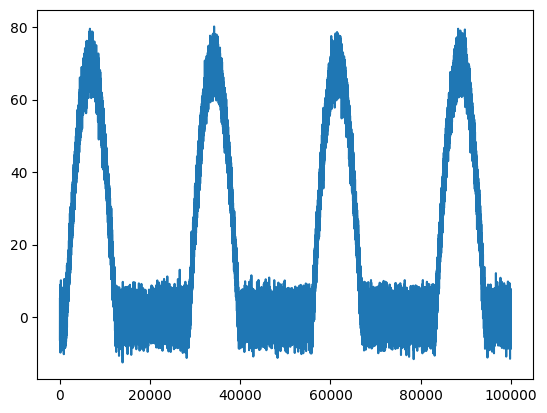

In [ ]:
make_pulses(device_t, period, 100.0, out=device_pulses)
waveform = add_ufunc(device_pulses, device_noise)
waveform = waveform.copy_to_host()
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

#### Exercise3

The following exercise will require you to utilize everything you've learned so far to GPU-accelerate neural network calculations. Unlike previous exercises, there will not be any solution code available to you. Just like in this section, the other 2 notebooks in this course also have assessment problems. For those of you who successfully complete all 3, you will receive a certificate of competency in the course.

Please read the directions carefully before beginning your work to ensure the best chance at successfully completing the assessment.

Accelerate Neural Network Calculations

You will be refactoring a simple version of some code that performs work needed to create a hidden layer in a neural network. It normalizes grayscale values, weighs them, and applies an activation function.
Your task is to move this work to the GPU using the techniques you've learned while retaining the correctness of the calculations.

Load Imports and Initialize Values

In [ ]:
# Our hidden layer will contain 1M neurons.

n = 1000000

greyscales = np.floor(np.random.uniform(0, 255, n).astype(np.float32))
weights = np.random.normal(.5, .1, n).astype(np.float32)
from math import exp
@vectorize(['float32(float32)'], target='cuda')
def normalize(grayscales):
    return grayscales / 255

@vectorize(['float32(float32,float32)'], target='cuda')
def weigh(values, weights):
    return values * weights

@vectorize(['float32(float32)'], target='cuda')
def activate(values):
    return ( exp(values) - exp(-values) ) / ( exp(values) + exp(-values) )


In [ ]:
def create_hidden_layer(n, greyscales, weights, exp, normalize, weigh, activate):

    device_greyscales = cuda.to_device(greyscales)
    device_weights = cuda.to_device(weights)

    normalized = normalize(device_greyscales)
    weighted = weigh(normalized, device_weights)
    activated = activate(weighted)

    # The assessment mechanism will expect `activated` to be a host array, so,
    # even after you refactor this code to run on the GPU, make sure to explicitly copy
    # `activated` back to the host.
    out_host = activated.copy_to_host()
    return activated